c:\Repositories\seu-injection-framework\venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Repositories\seu-injection-framework\venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_32_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_32_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\Repositories\seu-injection-framework\venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also u

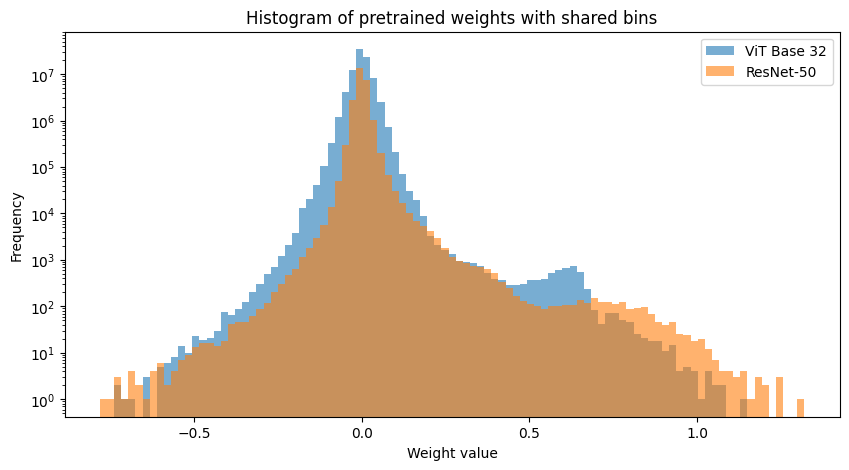

In [1]:
import torch
import torchvision.models as models
import matplotlib.pyplot as plt
import numpy as np

# Load pretrained models
vit = models.vit_b_32(pretrained=True)
resnet = models.resnet50(pretrained=True)

# Flatten weights
vit_weights = torch.cat([p.data.flatten() for p in vit.parameters()]).cpu().numpy()
resnet_weights = torch.cat([p.data.flatten() for p in resnet.parameters()]).cpu().numpy()

# Define common bin edges based on combined min/max
min_val = min(vit_weights.min(), resnet_weights.min())
max_val = max(vit_weights.max(), resnet_weights.max())

bins = np.linspace(min_val, max_val, 100)

plt.figure(figsize=(10,5))
plt.hist(vit_weights, bins=bins, alpha=0.6, label='ViT Base 32', density=False)
plt.hist(resnet_weights, bins=bins, alpha=0.6, label='ResNet-50', density=False)
plt.legend()
plt.title('Histogram of pretrained weights with shared bins')
plt.xlabel('Weight value')
plt.ylabel('Frequency')
plt.yscale("log")
plt.show()


C:\Users\wwden\AppData\Local\Temp\ipykernel_15804\3787537212.py:52: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("viridis")


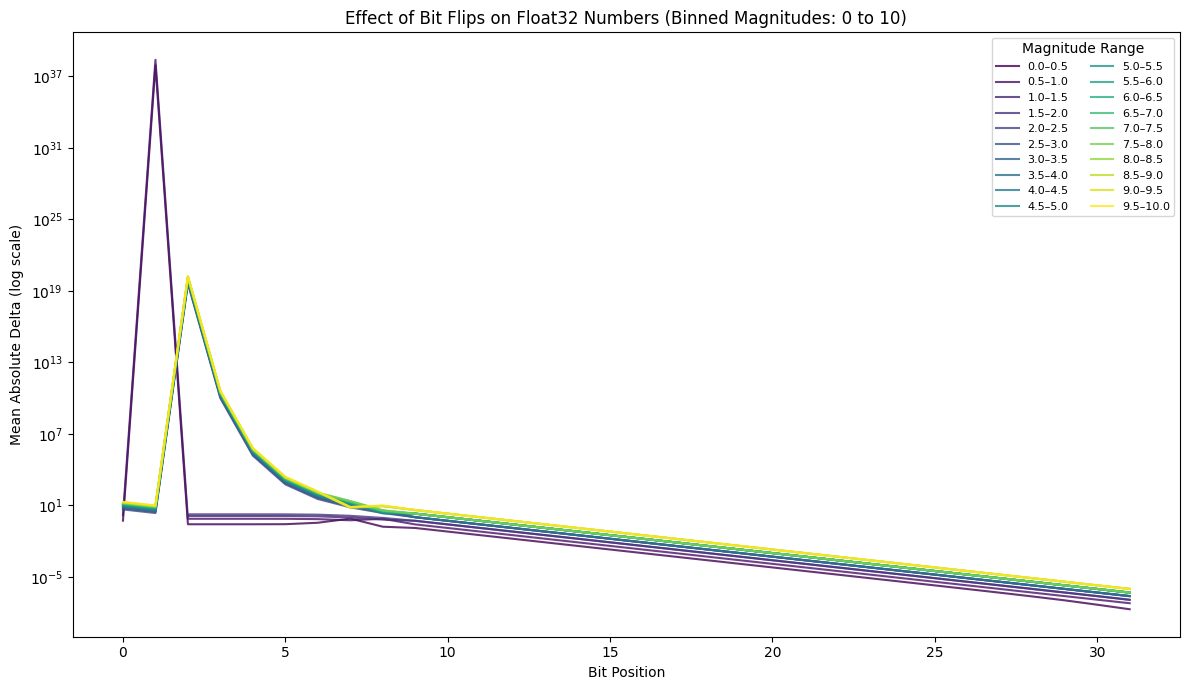

In [2]:
import numpy as np
import struct
import matplotlib.pyplot as plt
import matplotlib.cm as cm

def bitflip_float32(x, bit_i=np.random.randint(0, 32)):
    if hasattr(x, "__iter__"):
        x_ = np.zeros_like(x, dtype=np.float32)
        for i, item in enumerate(x):
            string = list(float32_to_binary(item))
            string[bit_i] = "0" if string[bit_i] == "1" else "1"
            x_[i] = binary_to_float32("".join(string))
    else:
        string = list(float32_to_binary(x))
        string[bit_i] = "0" if string[bit_i] == "1" else "1"
        x_ = binary_to_float32("".join(string))
    return x_

def float32_to_binary(f):
    [bits] = struct.unpack("!I", struct.pack("!f", f))
    return f"{bits:032b}"

def binary_to_float32(binary_str):
    bits = int(binary_str, 2)
    return struct.unpack("!f", struct.pack("!I", bits))[0]

def assess_deltas(arr, bit_i):
    flipped_arr = np.apply_along_axis(lambda x: bitflip_float32(x, bit_i), axis=0, arr=arr)
    mask = np.isfinite(flipped_arr)
    return np.median(np.abs(arr - flipped_arr))

n = 1000
step = 0.5
edges = np.arange(0, 10, step)
ranges = []
labels = []

for low in edges:
    high = low + step
    magnitudes = np.random.uniform(low + 1e-6, high, size=n)
    signed_vals = magnitudes * np.random.choice([-1, 1], size=n)
    ranges.append(signed_vals)
    labels.append(f"{low}–{high}")

deltas = [[] for _ in ranges]

for i in range(32):
    for j, arr in enumerate(ranges):
        deltas[j].append(assess_deltas(arr, i))

plt.figure(figsize=(12, 7))
cmap = cm.get_cmap("viridis")

for idx, (d, label) in enumerate(zip(deltas, labels)):
    color = cmap(idx / (len(deltas) - 1))
    plt.plot(d, label=label, linewidth=1.5, alpha=0.8, color=color)

plt.yscale("log")
plt.xlabel("Bit Position")
plt.ylabel("Mean Absolute Delta (log scale)")
plt.title("Effect of Bit Flips on Float32 Numbers (Binned Magnitudes: 0 to 10)")
plt.legend(title="Magnitude Range", fontsize=8, ncol=2)
plt.tight_layout()
plt.savefig("bitflips_deltas_gradient_colors.pdf")
plt.show()


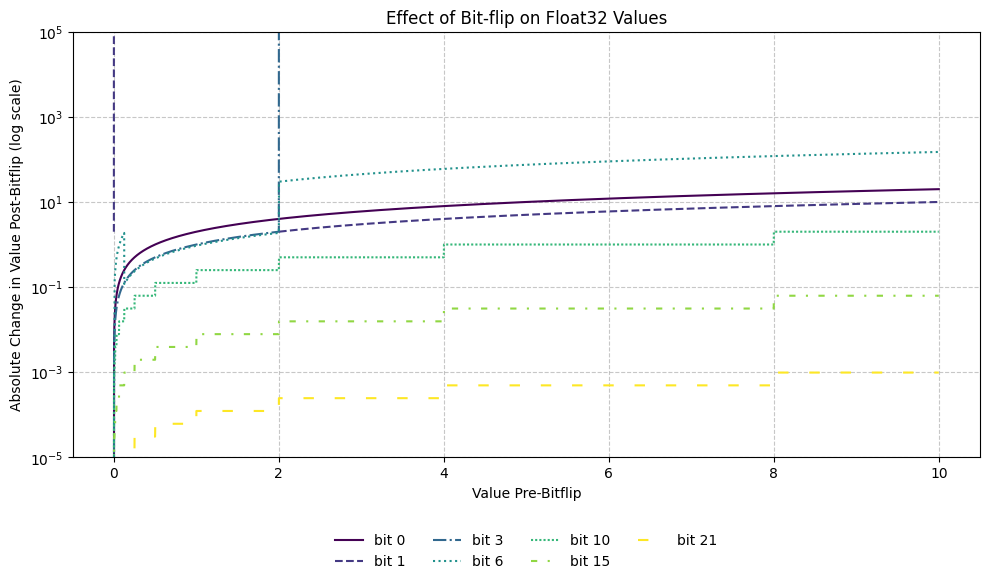

In [6]:
import numpy as np
import matplotlib.pyplot as plt

values = np.linspace(0, 10, 10007)
bit_is = [0, 1, 3, 6, 10, 15, 21]

colors = plt.cm.viridis(np.linspace(0, 1, len(bit_is)))
linestyles = ['-', '--', '-.', ':', (0, (1, 1)), (0, (3, 5, 1, 5)), (0, (5, 10))]

plt.figure(figsize=(10, 6))

for bi, c, ls in zip(bit_is, colors, linestyles):
    y = [bitflip_float32(v, bi) for v in values]
    y = np.abs(np.array(y) - values)
    plt.plot(values, y, label=f'bit {bi}', color=c, linestyle=ls, linewidth=1.5)
    # Add markers sparsely to avoid clutter
    #plt.plot(values[::1000], np.array(y)[::1000], marker='o', color=c, linestyle='None', markersize=5)


plt.yscale('log')
plt.grid(True, which='both', linestyle='--', alpha=0.7)
plt.legend(ncol=4, bbox_to_anchor=(0.5, -0.15), loc='upper center', frameon=False)
plt.xlabel('Value Pre-Bitflip')
plt.ylabel('Absolute Change in Value Post-Bitflip (log scale)')
plt.title('Effect of Bit-flip on Float32 Values')
plt.ylim(1e-5,1e5)

plt.tight_layout()
plt.savefig("Advanced_bitflip_impact.pdf")
plt.show()

